In [16]:
#KNN
from sklearn.ensemble import RandomForestClassifier
from numpy.lib.arraypad import pad
from sklearn import neighbors
from sklearn.base import clone
from itertools import combinations
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA

#load the data from .csv file
data = pd.read_csv('.\\mobile\\train.csv')

x_data = data.iloc[:,:-1].values
y_data = data.iloc[:,20].values
data

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


Unfortunately we need to split our train data into train and test data sets because the test data set provided by the author Abhishek Sharma does not contain the price data, which prevents us from checking algorithm accuracy.

In [13]:
#split data into train and test samples (ratio 70:30)
x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(x_data, y_data, test_size=0.30)

Also, in order the euclidean metric to work properly we standardized the data using standard scaler.

In [14]:
#standardize the data
scaler = StandardScaler()
scaler.fit(x_train_data)

x_train_data_scaled = scaler.transform(x_train_data)
x_test_data_scaled = scaler.transform(x_test_data)

In [18]:
x_train_data_scaled[2, :]

array([ 0.50846588, -0.9900495 ,  0.0930924 ,  0.96628239,  1.08931575,
        0.94846874,  0.40794678, -1.38229984, -1.69476134,  1.54629864,
        0.02405774,  0.37079208,  0.98704832,  1.72424333, -1.47396996,
       -0.61772267,  0.3843355 ,  0.54653573,  1.00429494, -1.02752143])

To check the algorithm accuracy we plotted the weighted accuracy score below for many different neighbors count.

In [11]:

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(x_train_data, y_train_data)
clf.score(x_test_data, y_test_data)


0.9216666666666666

The results are not really good. We only aquired accuracy rate on around 70 %. This is caused by the so called "Curse of Dimensionality".

Page [104]

"*It is important to mention that KNN is very susceptible to overfitting 
due to the curse of dimensionality. The curse of dimensionality 
describes the phenomenon where the feature space becomes 
increasingly sparse for an increasing number of dimensions of a fixed size training dataset. Intuitively, we can think of even the closest 
neighbors being too far away in a high-dimensional space to give a 
good estimate.*"

We have decided to reduce the amount of dimensions using SBS (Sequential Backward Selection) algorithm (implementation - Page [131]). 

In [ ]:
#Dimension reduction

class SBS():
  def __init__(self, estimator, k_features, 
    scoring=accuracy_score,
    test_size=0.25, random_state=1):
    self.scoring = scoring
    self.estimator = clone(estimator)
    self.k_features = k_features
    self.test_size = test_size
    self.random_state = random_state
  def fit(self, X, y):
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=self.test_size,
    random_state=self.random_state)
    dim = X_train.shape[1]
    self.indices_ = tuple(range(dim))
    self.subsets_ = [self.indices_]
    score = self._calc_score(X_train, y_train,
    X_test, y_test, self.indices_)
    self.scores_ = [score]
    while dim > self.k_features:
      scores = []
      subsets = []
      for p in combinations(self.indices_, r=dim - 1):
        score = self._calc_score(X_train, y_train, X_test, y_test, p)
        scores.append(score)
        subsets.append(p)
      best = np.argmax(scores)
      self.indices_ = subsets[best]
      self.subsets_.append(self.indices_)
      dim -= 1
      self.scores_.append(scores[best])
    self.k_score_ = self.scores_[-1]
    return self
  def transform(self, X):
    return X[:, self.indices_]
  def _calc_score(self, X_train, y_train, X_test, y_test, indices):
    self.estimator.fit(X_train[:, indices], y_train)
    y_pred = self.estimator.predict(X_test[:, indices])
    score = self.scoring(y_test, y_pred)
    return score

Firstly we have checked, how the overall accuracy behaves, depending on the amount of dimensions reduced and amount of neighbors.

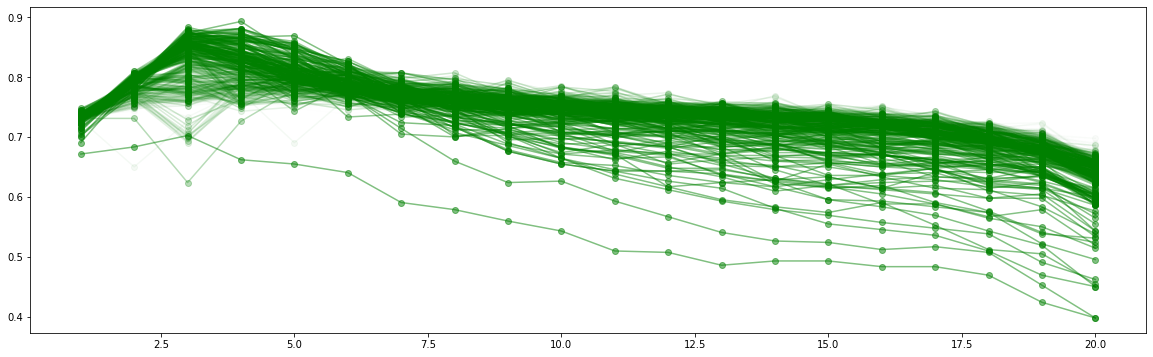

In [ ]:
best_neighbors_scores = []
best_neighbors_subsets = []
best_neighbors_count = []
for neighbors_count in range(2,350,1):
  knn = KNeighborsClassifier(n_neighbors=neighbors_count)
  sbs = SBS(knn, k_features=1, test_size=0.30)
  sbs.fit(x_train_data_scaled,y_train_data)
  k_feat = [len(k) for k in sbs.subsets_]
  if(len(best_neighbors_scores)==0):
    best_neighbors_scores.append(sbs.scores_)
    best_neighbors_subsets.append(sbs.subsets_)
    best_neighbors_count.append(neighbors_count)
  if(best_neighbors_scores[0][16]<sbs.scores_[16]):
    best_neighbors_scores.insert(0,sbs.scores_)
    best_neighbors_subsets.insert(0,sbs.subsets_)
    best_neighbors_count.insert(0,neighbors_count)
  figure(num=1, figsize=(20, 6))
  plt.plot(k_feat,sbs.scores_,marker='o', alpha=((350.0-neighbors_count)/350.0)/2.0, color='g')
  plt.grid()

We see that KNN scores the best results operating only on 4 out of 20 dimensions! Lets get the best results and see how many neighbors is optimal.

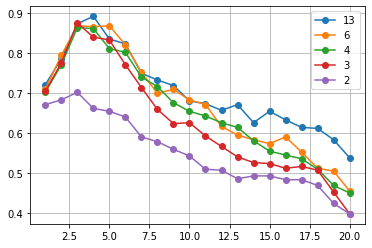

In [ ]:
for i in best_neighbors_scores:
  plt.plot(k_feat,i,marker='o')

figure(num=1, figsize=(20, 6))
plt.grid()
plt.legend(best_neighbors_count)

As we see, the best results were these where algorithm used 13 neighbors as the reference. Out of curiosity, lets check what are the features used in this algorithm.


In [ ]:
print(data.columns[0:][list(best_neighbors_subsets[0][16])])

Index(['battery_power', 'px_height', 'px_width', 'ram'], dtype='object')


We have gotten our best set of features. Lets check if they are the same as the ones picked by the **random forest** algorithm.

 1) ram                            0.467413
 2) battery_power                  0.073957
 3) px_width                       0.058224
 4) px_height                      0.057895
 5) mobile_wt                      0.041701
 6) int_memory                     0.037151
 7) talk_time                      0.031119
 8) pc                             0.031056
 9) sc_w                           0.029836
10) clock_speed                    0.028823
11) sc_h                           0.028537
12) fc                             0.025840
13) m_dep                          0.024797
14) n_cores                        0.023569
15) four_g                         0.007273
16) touch_screen                   0.007142
17) dual_sim                       0.007050
18) blue                           0.006828
19) wifi                           0.006675
20) three_g                        0.005115


(-1.0, 20.0)

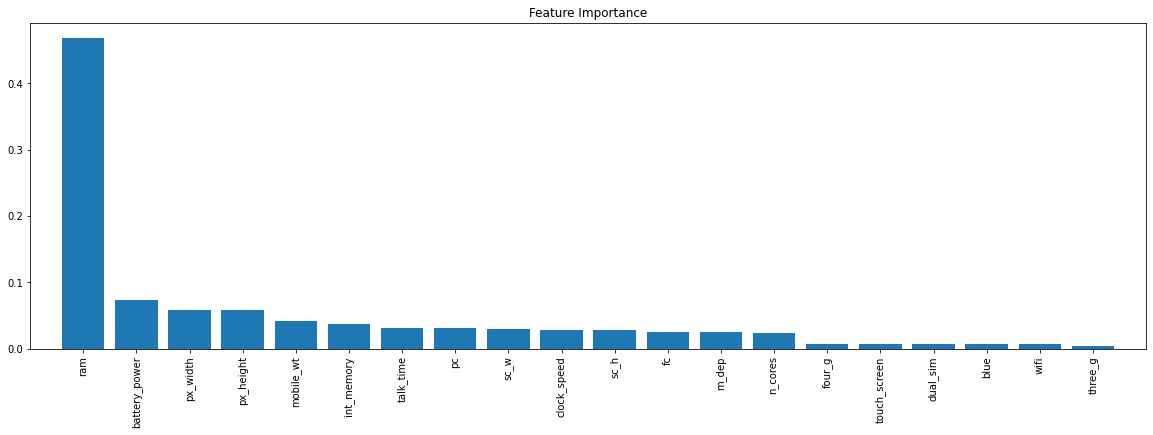

In [ ]:
feat_labels = data.columns[0:]
#print(feat_labels)
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(x_train_data,y_train_data)
importances = forest.feature_importances_
#print(importances)
indices = np.argsort(importances)[::-1]
#print(indices)
for f in range(x_train_data.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30,
  feat_labels[indices[f]],
  importances[indices[f]]))
figure(num=1, figsize=(20, 6))
plt.title('Feature Importance')
plt.bar(range(x_train_data.shape[1]), importances[indices], align='center')
plt.xticks(range(x_train_data.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1,x_train_data.shape[1]])

As we see the most important feature is ram. But four of the best are ram, battery_power, px_width, px_height and they are the same as the ones picked by SBS.

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
# setup marker generator and color map
  markers = ('s', 'x', 'o', '^', 'v')
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])
# plot the decision surface
  x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
  np.arange(x2_min, x2_max, resolution))
  Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
  Z = Z.reshape(xx1.shape)
  plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
      alpha=0.8, c=colors[idx],
      marker=markers[idx], label=cl, 
      edgecolor='black')
  # highlight test samples
  if test_idx:
# plot all samples
    X_test, y_test = X[test_idx, :], y[test_idx]
    plt.scatter(X_test[:, 0], X_test[:, 1],
      c='', edgecolor='black', alpha=1.0,
      linewidth=1, marker='o',
      s=100, label='test set')

0.9083333333333333


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


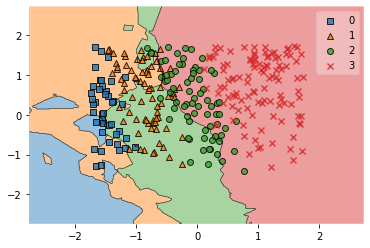

In [ ]:
from mlxtend.plotting import plot_decision_regions as plot_decisions

data_reduced_dimensions=data[['ram','battery_power','px_width','px_height','price_range']]
x_data_reduced_dimensions = data_reduced_dimensions.iloc[:,:-1].values
y_data_reduced_dimensions = data_reduced_dimensions.iloc[:,4].values

x_train_data_reduced_dimensions, x_test_data_reduced_dimensions, y_train_data_reduced_dimensions, y_test_data_reduced_dimensions = train_test_split(x_data_reduced_dimensions, y_data_reduced_dimensions, test_size=0.30)

scaler = StandardScaler()
scaler.fit(x_train_data_reduced_dimensions)

x_train_data_reduced_dimensions_scaled = scaler.transform(x_train_data_reduced_dimensions)
x_test_data_reduced_dimensions_scaled = scaler.transform(x_test_data_reduced_dimensions)
knn = KNeighborsClassifier(13)
knn.fit(x_train_data_reduced_dimensions_scaled, y_train_data_reduced_dimensions)
y_test_data_reduced_dimensions_predicted = knn.predict(x_test_data_reduced_dimensions_scaled)
accuracy = accuracy_score(y_test_data_reduced_dimensions,y_test_data_reduced_dimensions_predicted)
print(accuracy)
plot_decisions(x_train_data_reduced_dimensions_scaled,y_train_data_reduced_dimensions,clf=knn,feature_index=[0,2],                        #these one will be plotted  
              filler_feature_values={1:3, 3:3},  #these will be ignored
              filler_feature_ranges={1:3, 3:3})

0.5616666666666666


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


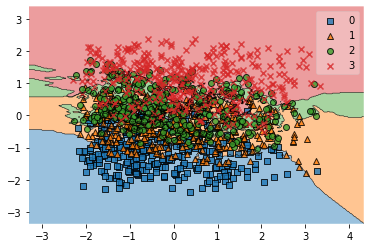

In [ ]:
pca = PCA(n_components=2)
knn = KNeighborsClassifier(n_neighbors=13)
x_train_data_reduced_dimensions_scaled_pca = pca.fit_transform(x_train_data_reduced_dimensions_scaled)
x_test_data_reduced_dimensions_scaled_pca = pca.fit_transform(x_test_data_reduced_dimensions_scaled)
knn.fit(x_train_data_reduced_dimensions_scaled_pca, y_train_data_reduced_dimensions)
y_test_data_reduced_dimensions_predicted_pca = knn.predict(x_test_data_reduced_dimensions_scaled_pca)
accuracy = accuracy_score(y_test_data_reduced_dimensions,y_test_data_reduced_dimensions_predicted_pca)
print(accuracy)

plot_decisions(x_train_data_reduced_dimensions_scaled_pca, y_train_data_reduced_dimensions, clf=knn)


0.26666666666666666


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


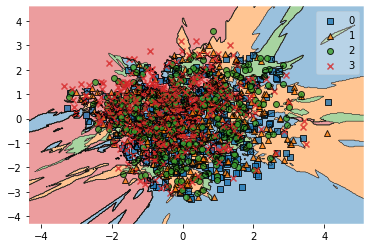

In [ ]:
pca = PCA(n_components=2)
knn = KNeighborsClassifier(n_neighbors=13)
x_train_data_scaled_pca = pca.fit_transform(x_train_data_scaled)
x_test_data_scaled_pca = pca.fit_transform(x_test_data_scaled)
knn.fit(x_train_data_scaled_pca, y_train_data)
y_test_data_predicted_pca = knn.predict(x_test_data_scaled_pca)
accuracy = accuracy_score(y_test_data_reduced_dimensions,y_test_data_predicted_pca)
print(accuracy)

plot_decisions(x_train_data_scaled_pca, y_train_data, clf=knn)
